In [1]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split


In [2]:
# # datasets

# categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
# quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
# connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
# train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

# print(train_data.info())

In [3]:
# merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
# merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
# merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

# print(merged_data)
# print("Shape after dropping missing values:", merged_data.shape)


In [4]:
# # missing values
# merged_data.isnull().sum()

# merged_data_clean = merged_data.dropna()

# # merged_data_clean.isnull().sum()
# print("Shape after dropping missing values:", merged_data_clean.shape)



In [5]:
# categorical_cols = merged_data_clean.select_dtypes(include='object').columns
# print(categorical_cols)

In [6]:
# # target variables
# y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]

# # dropping participant_id and target variables
# X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)


In [7]:

# X_scaled = StandardScaler().fit_transform(X)


In [8]:
# # train - test split data

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=108)



In [9]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import RandomForestClassifier

# model = MultiOutputClassifier(RandomForestClassifier())
# model.fit(X_train, y_train)  # y_train is a DataFrame with two columns: ['ADHD_Outcome', 'Sex_F']


In [10]:
# # Pseudo-Keras
# shared = Dense(256, activation='relu')(input)
# adhd_output = Dense(1, activation='sigmoid', name='adhd')(shared)
# sex_output = Dense(1, activation='sigmoid', name='sex')(shared)

# model = Model(inputs=input, outputs=[adhd_output, sex_output])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# !pip install lightgbm

In [12]:
# !pip install catboost

In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, classification_report

In [14]:


# # --- Load your data ---
# # Assume X contains all features (combined fMRI + tabular), and y contains the two target columns
# # Replace this with your actual loading/processing step
# # X = pd.read_csv('processed_features.csv')
# # y = pd.read_csv('targets.csv')[['ADHD_Outcome', 'Sex_F']]


# # --- Define models ---
# models = {
#     # 'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
#     # 'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
#     # 'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=42)),
#     'CatBoost': MultiOutputClassifier(CatBoostClassifier(iterations=100 ,verbose=0, random_state=42))
# }

# # --- Evaluate each model ---
# results = []

# for name, model in models.items():
#     print(f"\nTraining {name}...")
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])
#     sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])
    
#     results.append({
#         'Model': name,
#         'ADHD_Accuracy': adhd_acc,
#         'Sex_Accuracy': sex_acc,
#         'Average_Accuracy': np.mean([adhd_acc, sex_acc])
#     })

#     print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
#     print(classification_report(y_test, y_pred, target_names=['ADHD_Outcome', 'Sex_F'], zero_division=0))

# # --- Show summary ---
# results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
# print("\nModel Comparison Summary:")
# print(results_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
Shape before dropping missing values: (1213, 19930)
Shape after dropping missing values: (619, 19930)
Categorical Columns: Index(['participant_id'], dtype='object')
Automatically selected 502 PCA components to retain 95.0% of variance.
Shape after PCA reduction: (619, 502)


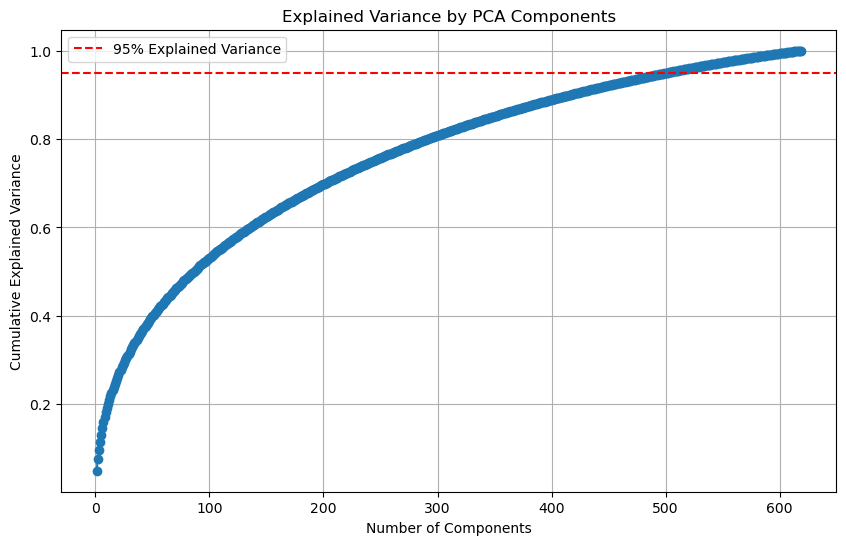


Evaluating Random Forest with 5-fold Cross-Validation...
Random Forest - ADHD Accuracy: 0.6866, Sex Accuracy: 0.6671, Average: 0.6769

Evaluating Logistic Regression with 5-fold Cross-Validation...
Logistic Regression - ADHD Accuracy: 0.5833, Sex Accuracy: 0.6865, Average: 0.6349

Evaluating LightGBM with 5-fold Cross-Validation...
[LightGBM] [Info] Number of positive: 164, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82981
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331313 -> initscore=-0.702252
[LightGBM] [Info] Start training from score -0.702252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

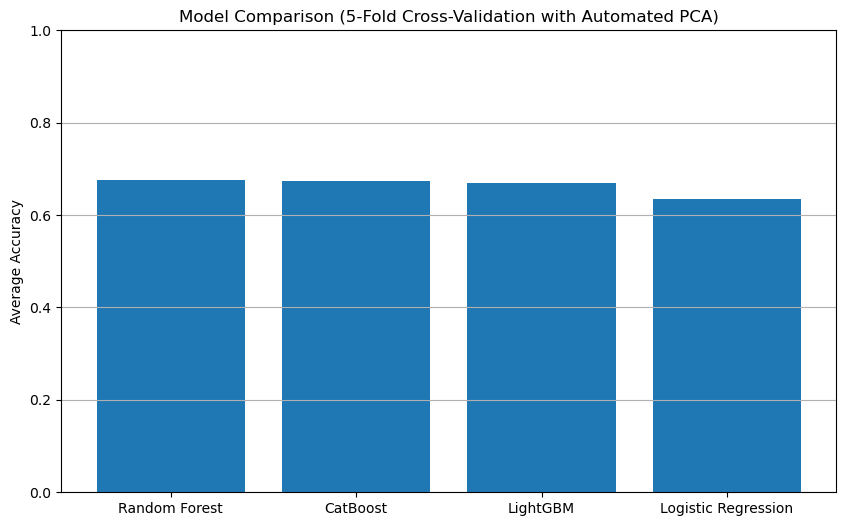

In [20]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np

# --- Load datasets ---
categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

print(train_data.info())

# --- Merge datasets ---
merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

print("Shape before dropping missing values:", merged_data.shape)

# --- Handle missing values ---
merged_data_clean = merged_data.dropna()
print("Shape after dropping missing values:", merged_data_clean.shape)

# --- Separate features and targets ---
categorical_cols = merged_data_clean.select_dtypes(include='object').columns
print("Categorical Columns:", categorical_cols)

# Targets
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]

# Drop participant_id and target columns
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

# --- Standardize features ---
X_scaled = StandardScaler().fit_transform(X)

# --- PCA for Dimensionality Reduction (Automatic selection) ---
target_variance = 0.95  # Target 95% explained variance

# Step 1: Full PCA
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

# Step 2: Calculate cumulative explained variance
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Step 3: Find number of components to reach target variance
n_components = np.argmax(explained_variance_ratio >= target_variance) + 1

print(f"Automatically selected {n_components} PCA components to retain {target_variance*100:.1f}% of variance.")

# Step 4: Apply PCA again with selected number of components
pca_final = PCA(n_components=n_components, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Shape after PCA reduction: {X_pca.shape}")

# --- Plot explained variance ---
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance*100)}% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.legend()
plt.show()

# --- Define models ---
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(iterations=100, verbose=0, random_state=42)
}

# --- Define custom scorer for MultiOutput ---
def multioutput_accuracy_per_target(y_true, y_pred):
    """Returns a tuple: (ADHD accuracy, Sex accuracy, mean)"""
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])
    avg_acc = np.mean([adhd_acc, sex_acc])
    return adhd_acc, sex_acc, avg_acc

def multioutput_avg_accuracy(y_true, y_pred):
    """Only returns the average accuracy for scoring"""
    _, _, avg_acc = multioutput_accuracy_per_target(y_true, y_pred)
    return avg_acc

multioutput_scorer = make_scorer(multioutput_avg_accuracy)

# --- Evaluate models with Cross-Validation ---
results = []

for name, base_model in models.items():
    print(f"\nEvaluating {name} with 5-fold Cross-Validation...")
    
    model = MultiOutputClassifier(base_model)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    adhd_accuracies = []
    sex_accuracies = []
    
    for train_index, test_index in kf.split(X_pca):
        X_train_cv, X_test_cv = X_pca[train_index], X_pca[test_index]
        y_train_cv, y_test_cv = y.values[train_index], y.values[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        
        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)
    
    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])
    
    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })
    
    print(f"{name} - ADHD Accuracy: {mean_adhd_acc:.4f}, Sex Accuracy: {mean_sex_acc:.4f}, Average: {avg_acc:.4f}")

# --- Summarize Results ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)

print("\nCross-Validation Model Comparison Summary:")
print(results_df)

# --- Optional: Plotting Results ---
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold Cross-Validation with Automated PCA)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# datasets

categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

print(train_data.info())

merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

print(merged_data)
print("Shape after dropping missing values:", merged_data.shape)

# missing values
merged_data.isnull().sum()

merged_data_clean = merged_data.dropna()

# merged_data_clean.isnull().sum()
print("Shape after dropping missing values:", merged_data_clean.shape)


categorical_cols = merged_data_clean.select_dtypes(include='object').columns
print(categorical_cols)

# target variables
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]

# dropping participant_id and target variables
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

X_scaled = StandardScaler().fit_transform(X)

# train - test split data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=108)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report



# --- Load your data ---
# Assume X contains all features (combined fMRI + tabular), and y contains the two target columns
# Replace this with your actual loading/processing step
# X = pd.read_csv('processed_features.csv')
# y = pd.read_csv('targets.csv')[['ADHD_Outcome', 'Sex_F']]


# --- Define models ---
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=108)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=108))
}

# --- Evaluate each model ---
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])
    sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])
    
    results.append({
        'Model': name,
        'ADHD_Accuracy': adhd_acc,
        'Sex_Accuracy': sex_acc,
        'Average_Accuracy': np.mean([adhd_acc, sex_acc])
    })

    print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ADHD_Outcome', 'Sex_F'], zero_division=0))

# --- Show summary ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
     participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0      00aIpNTbG5uh                     2019                       4   
1      00fV0OyyoLfw                     2017                       1   
2      04X1eiS79T4B                     2017                       1   
3      05ocQutkURd6                     2018                       1   
4      06YUNBA9ZRLq                     2018                       1   
...             ...                      ...                     ...   
1208   zwjJWCRzKhDz                     2019                       4   
1209   zwXD5v17Rx01                     20

In [22]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 12.7 MB/s eta 0:00:12
   - -------------------------------------- 4.5/150.0 MB 14.9 MB/s eta 0:00:10
   -- ------------------------------------- 7.6/150.0 MB 15.2 MB/s eta 0:00:10
   -- ------------------------------------- 9.7/150.0 MB 13.1 MB/s eta 0:00:11
   --- ------------------------------------ 12.3/150.0 MB 13.1 MB/s eta 0:00:11
   ---- ----------------------------------- 15.5/150.0 MB 13.3 MB/s eta 0:00:11
   ----- ---------------------------------- 18.9/150.0 MB 13.9 MB/s eta 0:00:10
   ----- ---------------------------------- 22.3/150.0 MB 14.1 MB/s eta 0:00:10
   ------ --------------------------------- 25.7/150.0 MB 14.4 MB/s eta 0:00:09
   ------- -------------------------------- 29.1/150.0 MB 14.5 MB/s eta 0:00:09
   -------- ------------------------------- 32.2/150.0 MB 14.6 MB/s eta 0:00:09
   --------- ------------------------------ 35.7/150.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
Shape before dropping missing values: (1213, 19930)
Shape after dropping missing values: (619, 19930)
Automatically selected 502 PCA components to retain 95.0% of variance.
Shape after PCA reduction: (619, 502)


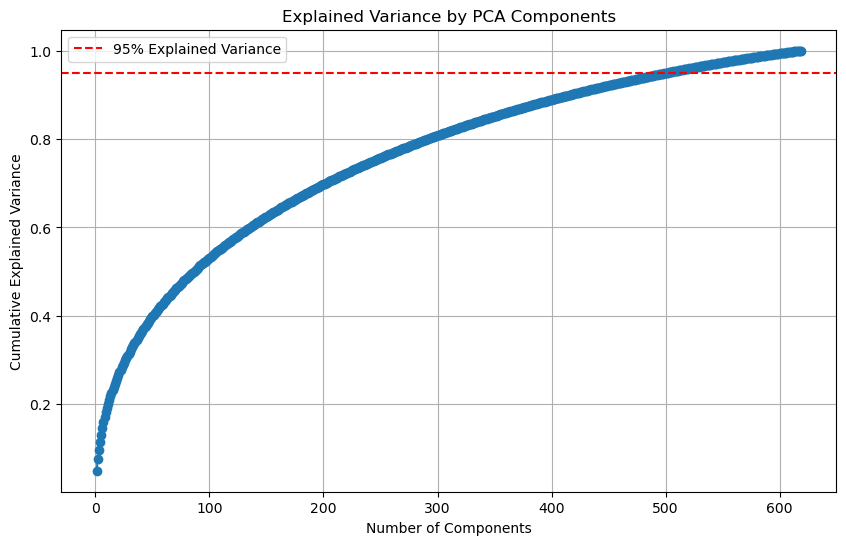


Evaluating Random Forest with 5-fold Stratified Cross-Validation...
Random Forest - ADHD Accuracy: 0.6882, Sex Accuracy: 0.6655, Average: 0.6769

Evaluating Logistic Regression with 5-fold Stratified Cross-Validation...
Logistic Regression - ADHD Accuracy: 0.6284, Sex Accuracy: 0.6995, Average: 0.6639

Evaluating LightGBM with 5-fold Stratified Cross-Validation...
[LightGBM] [Info] Number of positive: 165, number of negative: 330
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82993
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

C:\Users\ual-laptop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ual-laptop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ual-laptop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ual-laptop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

XGBoost - ADHD Accuracy: 0.6866, Sex Accuracy: 0.6462, Average: 0.6664

Evaluating Extra Trees with 5-fold Stratified Cross-Validation...
Extra Trees - ADHD Accuracy: 0.6882, Sex Accuracy: 0.6655, Average: 0.6769

Final Cross-Validation Model Comparison Summary:
                 Model  ADHD_Accuracy  Sex_Accuracy  Average_Accuracy
0        Random Forest       0.688211      0.665526          0.676869
5          Extra Trees       0.688211      0.665526          0.676869
3             CatBoost       0.689824      0.662300          0.676062
2             LightGBM       0.686612      0.663952          0.675282
4              XGBoost       0.686585      0.646197          0.666391
1  Logistic Regression       0.628429      0.699462          0.663946


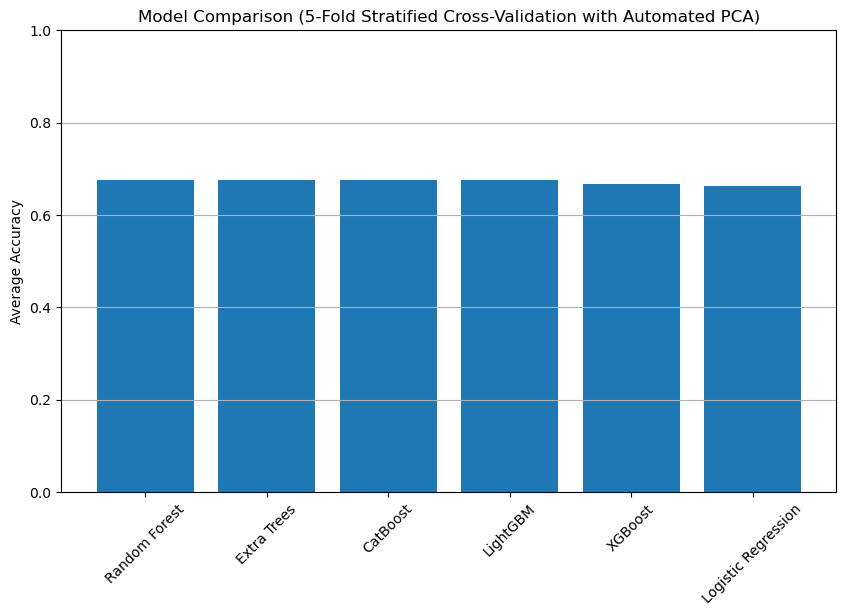

In [23]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np

# --- Load datasets ---
categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

print(train_data.info())

# --- Merge datasets ---
merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

print("Shape before dropping missing values:", merged_data.shape)

# --- Handle missing values ---
merged_data_clean = merged_data.dropna()
print("Shape after dropping missing values:", merged_data_clean.shape)

# --- Separate features and targets ---
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

# --- Standardize features ---
X_scaled = StandardScaler().fit_transform(X)

# --- PCA with Automatic Component Selection ---
target_variance = 0.95  # Target explained variance threshold

pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(explained_variance_ratio >= target_variance) + 1

print(f"Automatically selected {n_components} PCA components to retain {target_variance*100:.1f}% of variance.")

pca_final = PCA(n_components=n_components, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Shape after PCA reduction: {X_pca.shape}")

# --- Plot explained variance ---
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance*100)}% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.legend()
plt.show()

# --- Define models ---
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=500, depth=8, learning_rate=0.05, verbose=0, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=200, max_depth=10, random_state=42)
}

# --- Define custom scoring ---
def multioutput_accuracy_per_target(y_true, y_pred):
    """Returns (ADHD accuracy, Sex accuracy, average accuracy)."""
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])
    avg_acc = np.mean([adhd_acc, sex_acc])
    return adhd_acc, sex_acc, avg_acc

# --- Evaluate models ---
results = []

for name, base_model in models.items():
    print(f"\nEvaluating {name} with 5-fold Stratified Cross-Validation...")
    
    model = MultiOutputClassifier(base_model)
    
    kf_adhd = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kf_sex = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    adhd_accuracies = []
    sex_accuracies = []
    
    # ADHD Stratified KFold
    for (train_idx, test_idx), (train_idx_sex, test_idx_sex) in zip(kf_adhd.split(X_pca, y['ADHD_Outcome']),
                                                                    kf_sex.split(X_pca, y['Sex_F'])):
        X_train_cv, X_test_cv = X_pca[train_idx], X_pca[test_idx]
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        
        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)
    
    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])
    
    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })
    
    print(f"{name} - ADHD Accuracy: {mean_adhd_acc:.4f}, Sex Accuracy: {mean_sex_acc:.4f}, Average: {avg_acc:.4f}")

# --- Summarize Results ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)

print("\nFinal Cross-Validation Model Comparison Summary:")
print(results_df)

# --- Optional: Plotting Results ---
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold Stratified Cross-Validation with Automated PCA)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()
